In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import cv2 
from PIL import Image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pytorch_lightning import LightningModule

import os
import sys
import random

sys.path.append("/home/tak/IBT/Image-back-translation")

In [2]:
class MixAugLitModule(LightningModule):
    def __init__(self, net, num_classes, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.net = net
        self.num_classes = num_classes
        # 나머지 코드

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "/nvme_data1/tak/train_10/"
caption_path = "/nvme_data1/tak/train_csv/train_csv/"

# cmia_08 = "/data1/ImageNet1K/train_acc/train/runs/2023-10-03_18-07-40/checkpoints/last.ckpt"
# base_line_path = "/data1/ImageNet1K/train_acc/train/runs/2023-10-02_19-14-25/checkpoints/last.ckpt"

cmia_08 = '/home/tak/IBT/Image-back-translation/logs/train/runs/2023-11-11_19-26-19/checkpoints/last.ckpt'
base_line = '/home/tak/IBT/Image-back-translation/logs/train/runs/2023-11-11_19-24-36/checkpoints/last.ckpt'

model_path = base_line

# Load the pre-trained model
model = MixAugLitModule.load_from_checkpoint(model_path)
model.eval()  # Set to evaluation mode
model.to(device)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(dataset_path, transform=transform)

# option 1. Load random image
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [11]:
# option 2. Load specific image
target_file_path = "/nvme_data1/tak/train_10/n01910747/n01910747_10025.JPEG"

# 해당 파일에 대한 인덱스를 찾습니다.
target_index = None
for i, (img_path, _) in enumerate(dataset.samples):
    if img_path == target_file_path:
        target_index = i
        break

if target_index is not None:
    # 이미지와 라벨을 로드합니다.
    input_image, label = dataset[target_index]
    input_batch = input_image.unsqueeze(0).to(device)
    label = torch.tensor([label])   
else:
    print(f"Could not find the file {target_file_path}")

In [12]:
def extract_path_end(path):
    parts = path.split('/')
    return '/'.join(parts[-2:]) if len(parts) >= 2 else None

In [17]:
# option 3. CMIA image
cmia_ind_path = "/home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train"

cmia_image_path = "/home/tak/IBT/Image-back-translation/n02676566_n04536866/17_35.jpg"
cmia_class1 = cmia_image_path.split("/")[-2].split("_")[0]
cmia_class2 = cmia_image_path.split("/")[-2].split("_")[1]
file_name1 = cmia_image_path.split("/")[-1].split("_")[0]
file_name2 = cmia_image_path.split("/")[-1].split("_")[1].split(".")[0]
label1 = dataset.class_to_idx[cmia_class1]
label2 = dataset.class_to_idx[cmia_class2]

origin_file_path1 = os.path.join(cmia_class1,cmia_class1 + "_" + file_name1 + ".JPEG")
origin_file_path2 = os.path.join(cmia_class2,cmia_class2 + "_" + file_name2 + ".JPEG")

cmia_image = Image.open(cmia_image_path)
cmia_batch = transform(cmia_image).unsqueeze(0).to(device)
cmia_image = cmia_batch.squeeze(0)

caption_path1 = os.path.join(caption_path, cmia_class1 + ".csv")
caption_path2 = os.path.join(caption_path, cmia_class2 + ".csv")

caption_csv1 = pd.read_csv(caption_path1, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python')
caption_csv2 = pd.read_csv(caption_path2, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python')

caption_csv1['path_end'] = caption_csv1['org_img_path'].apply(extract_path_end)
caption_csv2['path_end'] = caption_csv2['org_img_path'].apply(extract_path_end)

match1 = caption_csv1.loc[caption_csv1['path_end'] == origin_file_path1]['caption'].values[0]
match2 = caption_csv2.loc[caption_csv2['path_end'] == origin_file_path2]['caption'].values[0]


In [18]:
# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def __call__(self, x):
        self.gradients = None
        activations = None
        x_clone = x.clone()
        for name, module in self.model._modules.items():
            if name == self.target_layer:
                x_clone.register_hook(self.save_gradient)
                activations = x_clone
            x_clone = module(x_clone)
            if name == self.target_layer:
                break
        
        # Since you have already passed the target layer, you can perform avgpool and fc directly
        x_clone = self.model.avgpool(x_clone)
        x_clone = torch.flatten(x_clone, 1)
        x_clone = self.model.fc(x_clone)  # This should be [batch_size, num_classes]
        
        return activations, x_clone

In [19]:
with open ("map_cls.txt", "r") as f:
    id_to_class = {}
    for line in f:
        class_id, _, class_name = line.strip().split()
        id_to_class[class_id] = class_name


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------------------
Image path: /home/tak/IBT/Image-back-translation/n02676566_n04536866/17_35.jpg
Class 1 label: 3, Class 1 name: acoustic_guitar
Class 2 label: 5, Class 2 name: violin
Predicted label: 5, Predicted class name: violin
Second predicted label: 6, Second predicted class name: wall_clock
Caption: mixture of a close up of an acoustic guitar with strings and a young boy is playing a violin on the street 
-------------------------------------------------------------------


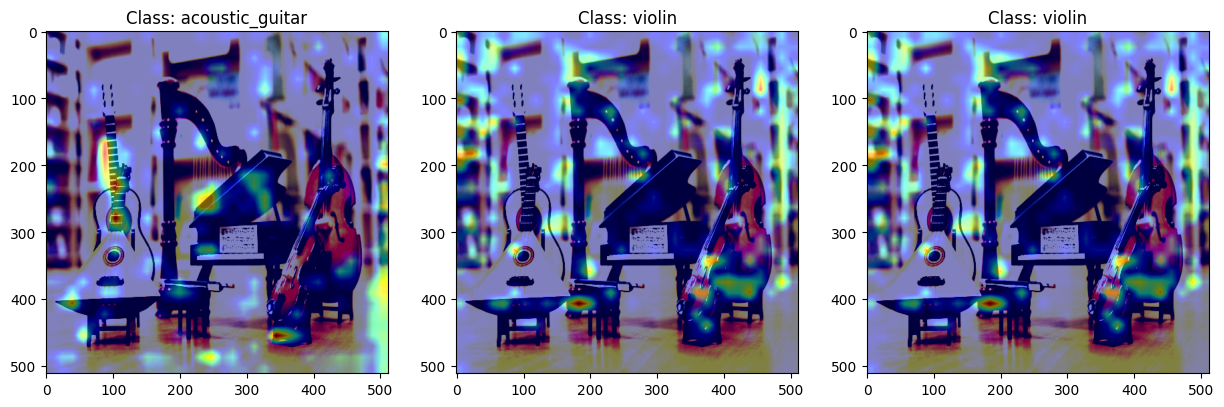

In [20]:
# GradCAM 객체 생성
grad_cam = GradCAM(model.net.model, target_layer="layer4")
activations, output = grad_cam(cmia_batch) 

_, predicted = output.max(1)
_, second_predicted = output.topk(2, 1)
print("-------------------------------------------------------------------")
print(f"Image path: {cmia_image_path}")
print(f"Class 1 label: {label1}, Class 1 name: {id_to_class[cmia_class1]}")
print(f"Class 2 label: {label2}, Class 2 name: {id_to_class[cmia_class2]}")
print(f"Predicted label: {predicted.item()}, Predicted class name: {id_to_class[dataset.classes[predicted.item()]]}")
print(f"Second predicted label: {second_predicted[0][1].item()}, Second predicted class name: {id_to_class[dataset.classes[second_predicted[0][1].item()]]}")
print(f"Caption: mixture of {match1} and {match2} ")
print("-------------------------------------------------------------------")

# 결과를 저장할 딕셔너리
cams = {}
classes_indices = [label1, label2, predicted.item()]

# 활성화 맵을 numpy 배열로 변환
activations_np = activations.data.cpu().numpy()[0]

# 모든 타겟 클래스에 대해서 CAM 계산
for class_index in classes_indices:
    # 모델 출력을 zero_grad로 초기화
    model.zero_grad()

    # 특정 클래스에 대한 확률 추출
    class_prob = output[0, class_index]

    # 특정 클래스에 대한 확률에 대해 backward를 수행하여 해당 클래스의 그래디언트를 계산
    class_prob.backward(retain_graph=True)

    # 그래디언트와 활성화 맵을 가져와 가중치를 계산
    gradients = grad_cam.gradients.data.cpu().numpy()[0]
    weights = np.mean(gradients, axis=(1, 2))

    # CAM 계산
    cam = np.zeros(activations_np.shape[1:], dtype=np.float32)
    for i, weight in enumerate(weights):
        cam += weight * activations_np[i, :, :]
    
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (512, 512))
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    cams[class_index] = cam

# 마지막 클래스에 대해서는 retain_graph를 False로 설정하여 그래프를 유지하지 않음
model.zero_grad()
class_prob = output[0, classes_indices[-1]]
class_prob.backward(retain_graph=False)

# 이미지를 numpy 배열로 변환
input_image_np = cmia_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# CAM 결과를 이미지와 함께 표시
plt.figure(figsize=(15, 5))
for i, class_index in enumerate(classes_indices):
    plt.subplot(1, len(classes_indices), i+1)
    plt.imshow(input_image_np)
    plt.imshow(cv2.resize(cams[class_index], (input_image_np.shape[0], input_image_np.shape[1])), alpha=0.5, cmap='jet')
    plt.title(f"Class: {id_to_class[dataset.classes[class_index]]}")
plt.show()


In [72]:
# skip this cell if you want option 2
input_image, label = next(iter(dataloader))
input_batch = input_image.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------------------
image_path : /data1/ImageNet1K/Annotations/Data/CLS-LOC/val_10/n07745940/ILSVRC2012_val_00000099.JPEG
True label: 0, Predicted label: 0

True class id:      n01910747, True class name:      jellyfish
Predicted class id: n01910747, Predicted class name: jellyfish
-------------------------------------------------------------------


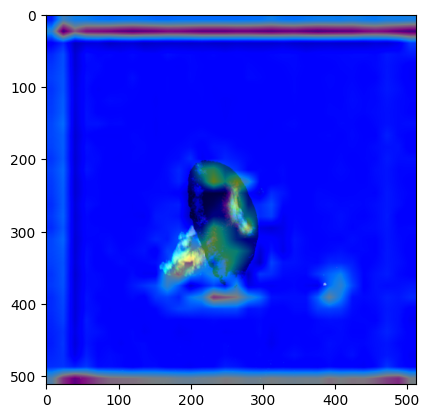

In [73]:
# GradCAM 객체 생성
grad_cam = GradCAM(model.net.model, target_layer="layer4")
activations, output = grad_cam(input_batch) 
_, predicted = output.max(1)
print("-------------------------------------------------------------------")
print(f"image_path : {dataset.samples[target_index][0]}")
print(f"True label: {label.item()}, Predicted label: {predicted.item()}\n")
print(f"True class id:      {dataset.classes[label.item()]}, True class name:      {id_to_class[dataset.classes[label.item()]]}")
print(f"Predicted class id: {dataset.classes[predicted.item()]}, Predicted class name: {id_to_class[dataset.classes[predicted.item()]]}")
print("-------------------------------------------------------------------")

# 가장 가능성 높은 클래스에 대한 확률을 선택
# 여기를 수정했습니다. 배치의 첫 번째 예제에 대한 예측만을 사용하도록 변경했습니다.
target_class = predicted[0].squeeze().item()
predicted_prob = output[0, target_class]

# backward pass
predicted_prob.backward()

# Compute CAM
gradients = grad_cam.gradients.data.cpu().numpy()[0]
activations = activations.data.cpu().numpy()[0]
weights = np.mean(gradients, axis=(1, 2))
cam = np.zeros(activations.shape[1:], dtype=np.float32)

for i, weight in enumerate(weights):
    cam += weight * activations[i, :, :]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (512, 512))
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
cam_resized = cv2.resize(cam, (input_image.size()[2], input_image.size()[2]))

# Display results
input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
plt.imshow(input_image_np)
plt.imshow(cam_resized, alpha=0.5, cmap='jet')
plt.show()
